In [26]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Polygon

In [16]:
n_points = 2000
eps = 1e-3
noise_std = 0.2

h_start = 0.1
h_min = 0.02
a = np.sqrt(2)

In [17]:
x = np.linspace(eps, 1.0, n_points)
y_clean = (1 + 0.5 * np.sin(4 * np.pi * x)) * np.sin(2 * np.pi * (6 * x + 12 * x**3))

np.random.seed(42)
noise = np.random.normal(scale=noise_std, size=n_points)
y_noisy = y_clean + noise

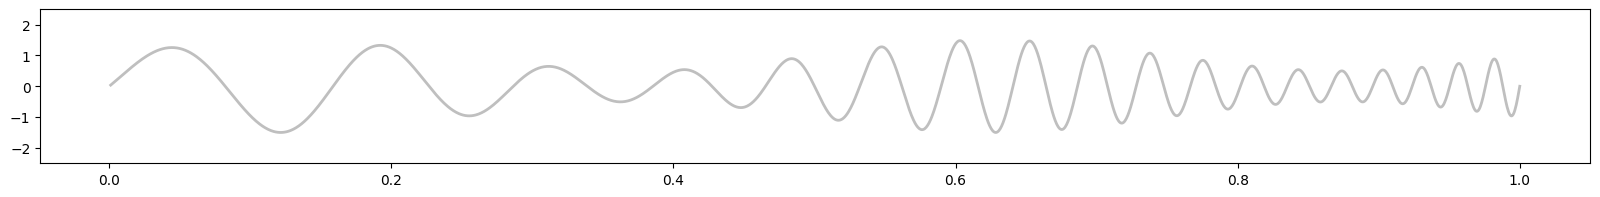

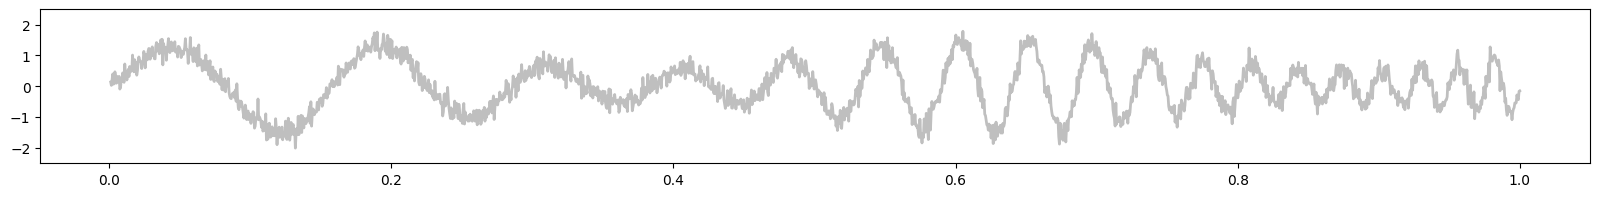

In [18]:
plt.figure(figsize=(20, 2))
plt.plot(x, y_clean, color='gray', linewidth=2, alpha=0.5)
plt.ylim(-2.5, 2.5)
plt.show()

plt.figure(figsize=(20, 2))
plt.plot(x, y_noisy, color='gray', linewidth=2, alpha=0.5)
plt.ylim(-2.5, 2.5)
plt.show()

In [19]:
residuals_list = []
components = []
current_residuals = y_noisy.copy()
h_curr = h_start

count = 0
while h_curr >= h_min:
    count += 1
    print("Step", count, "| h =", round(h_curr, 4))
    n = len(x)
    y_smooth = np.zeros(n)
    
    for i in range(n):
        t = x[i]
        
        indices = np.where((x >= t - h_curr) & (x <= t + h_curr))[0]        # Rolling Window
        local_res = current_residuals[indices]
            
        u = (x[indices] - t) / h_curr                                       # s - t / h
        weights = 0.75 * (1 - u**2)                                         # Epanechnikov Kernel
        weights[weights < 0] = 0
        weights = weights / (weights.sum())
        # print(weights.sum())
        
        def loss_function(m):
            return np.sum(np.abs(local_res - m) * weights)
        result = minimize_scalar(loss_function)
    
        if result.success:
            y_smooth[i] = result.x
        
    components.append(y_smooth)
    current_residuals = current_residuals - y_smooth
    #very important added by Marc in order to have the residuals from which we create the next IMF
    residuals_list.append(current_residuals)
    h_curr = h_curr / a

print()

###############################################


residuals_list_clean=[]
components_clean = []
current_residuals_clean = y_clean.copy()
h_curr = h_start

count = 0
while h_curr >= h_min:
    count += 1
    print("Step", count, "| h =", round(h_curr, 4))
    n = len(x)
    y_smooth = np.zeros(n)
    
    for i in range(n):
        t = x[i]
        
        indices = np.where((x >= t - h_curr) & (x <= t + h_curr))[0]            # Rolling Window
        local_res = current_residuals_clean[indices]
            
        u = (x[indices] - t) / h_curr                                           # s - t / h
        weights = 0.75 * (1 - u**2)                                             # Epanechnikov Kernel
        weights = weights / (weights.sum())
        
        def loss_function(m):
            return np.sum(np.abs(local_res - m) * weights)
        result = minimize_scalar(loss_function)
    
        if result.success:
            y_smooth[i] = result.x
        
    components_clean.append(y_smooth)
    current_residuals_clean = current_residuals_clean - y_smooth
    #very important added by Marc in order to have the residuals from which we create the next IMF
    residuals_list_clean.append(current_residuals_clean)
    h_curr = h_curr / a

Step 1 | h = 0.1
Step 2 | h = 0.0707
Step 3 | h = 0.05
Step 4 | h = 0.0354
Step 5 | h = 0.025

Step 1 | h = 0.1
Step 2 | h = 0.0707
Step 3 | h = 0.05
Step 4 | h = 0.0354
Step 5 | h = 0.025


In [25]:
def emd_decompose(y_input, x, h_start=0.1, h_min=0.02, a=np.sqrt(2)):
    residuals_list = []
    components = []
    current_residuals = y_input.copy()
    h_curr = h_start
    count = 0

    while h_curr >= h_min:
        count += 1
        print(f"Step {count} | h = {h_curr:.4f}")
        n = len(x)
        y_smooth = np.zeros(n)

        for i in range(n):
            t = x[i]
            
            indices = np.where((x >= t - h_curr) & (x <= t + h_curr))[0]    # Rolling Window
            local_res = current_residuals[indices]
                
            u = (x[indices] - t) / h_curr                                   # s - t / h
            weights = 0.75 * (1 - u**2)                                     # Epanechnikov Kernel
            weights = weights / (weights.sum())
            # print(weights.sum())
            
            def loss_function(m):
                return np.sum(np.abs(local_res - m) * weights)
            result = minimize_scalar(loss_function)
        
            if result.success:
                y_smooth[i] = result.x
            
        components.append(y_smooth)
        current_residuals = current_residuals - y_smooth

        residuals_list.append(current_residuals.copy())                     # Store residuals
        h_curr /= a
    
        final_resid = current_residuals.copy()
    return components, residuals_list, final_resid

def traditional_emd(y, x, max_imfs=5, max_sift=20, stop_std=0.2):
    signal = y.copy()
    n = len(y)
    
    imfs = []
    current_residual = signal.copy()
    
    for imf_idx in range(max_imfs):
        h = current_residual.copy()
        
        for sift_idx in range(max_sift):
            peaks = np.where((h[1:-1] > h[:-2]) & (h[1:-1] > h[2:]))[0] + 1
            troughs = np.where((h[1:-1] < h[:-2]) & (h[1:-1] < h[2:]))[0] + 1
            
            if len(peaks) < 2 or len(troughs) < 2:
                break
            
            peaks = np.concatenate(([0], peaks, [n-1]))
            troughs = np.concatenate(([0], troughs, [n-1]))
            
            up_env = CubicSpline(x[peaks], h[peaks])(x)
            low_env = CubicSpline(x[troughs], h[troughs])(x)
            
            mean_env = (up_env + low_env) / 2
            
            prev_h = h.copy()
            h = h - mean_env
            
            denom = prev_h**2
            denom[denom < 1e-10] = 1e-10
            sd = np.sum(((prev_h - h)**2) / denom)
            
            if sd < stop_std:
                break
        
        res_peaks = np.where((current_residual[1:-1] > current_residual[:-2]) & (current_residual[1:-1] > current_residual[2:]))[0]
        if len(res_peaks) < 2:
            break
            
        imfs.append(h)
        current_residual = current_residual - h

    return imfs, current_residual


# print("--- Decomposing Noisy Signal ---")
# components, residuals_list, final_resid = emd_decompose(y_noisy, x)

# print()
# print("--- Decomposing Clean Signal ---")
# components_clean, residuals_list_clean, final_resid_clean = emd_decompose(y_clean, x)

Step 1 | h = 0.1000
Step 2 | h = 0.0707
Step 3 | h = 0.0500
Step 4 | h = 0.0354
Step 5 | h = 0.0250


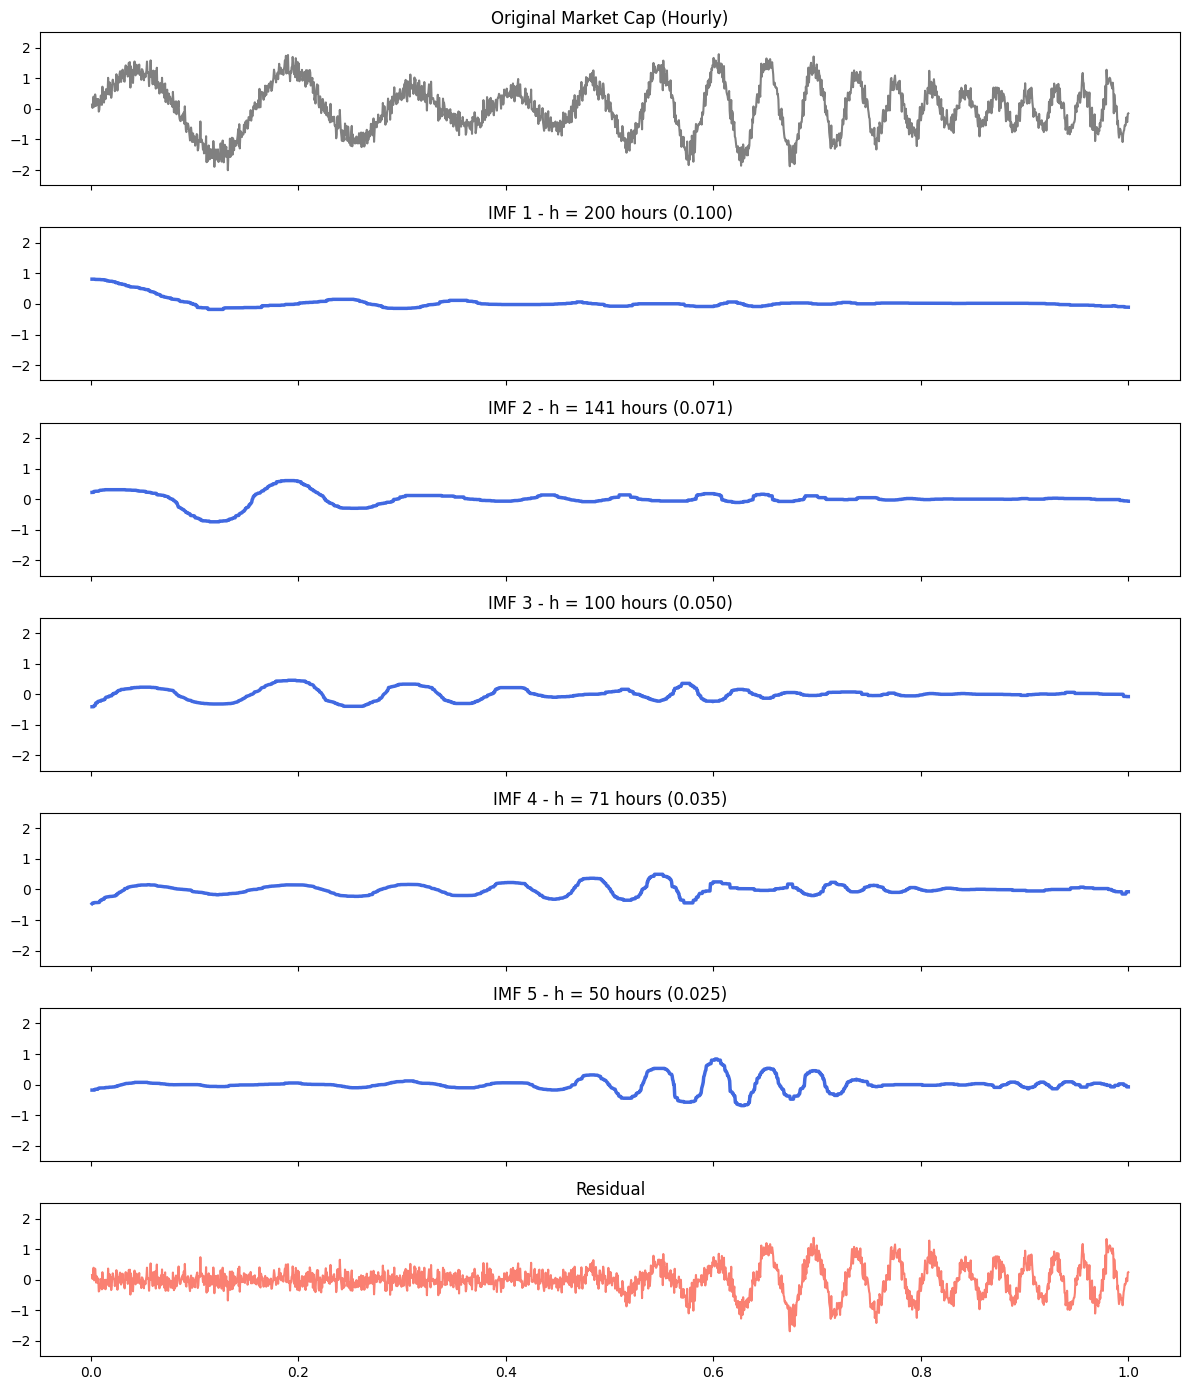

In [31]:
h_start = 0.1
h_min = 0.02
a_val = np.sqrt(2)

components, residuals_list, final_resid = emd_decompose(y_noisy, x, h_start, h_min, a_val)

n = len(y_noisy)
n_layers = len(components)
fig, axes = plt.subplots(n_layers + 2, 1, figsize=(12, 2 * (n_layers + 2)), sharex=True)

axes[0].plot(x, y_noisy, color='gray', linewidth=1.5)
axes[0].set_title("Original Market Cap (Hourly)")
axes[0].set_ylim(-2.5, 2.5)

current_h = h_start
for i in range(n_layers):
    axes[i+1].plot(x, components[i], color='royalblue', linewidth=2.5)
    axes[i+1].set_title(f"IMF {i+1} - h = {current_h * n:.0f} hours ({current_h:.3f})")
    axes[i+1].set_ylim(-2.5, 2.5)
    current_h /= a_val

axes[-1].plot(x, final_resid, color='salmon', linewidth=1.5)
axes[-1].set_title(f"Residual")
axes[-1].set_ylim(-2.5, 2.5)

plt.tight_layout()
plt.show()

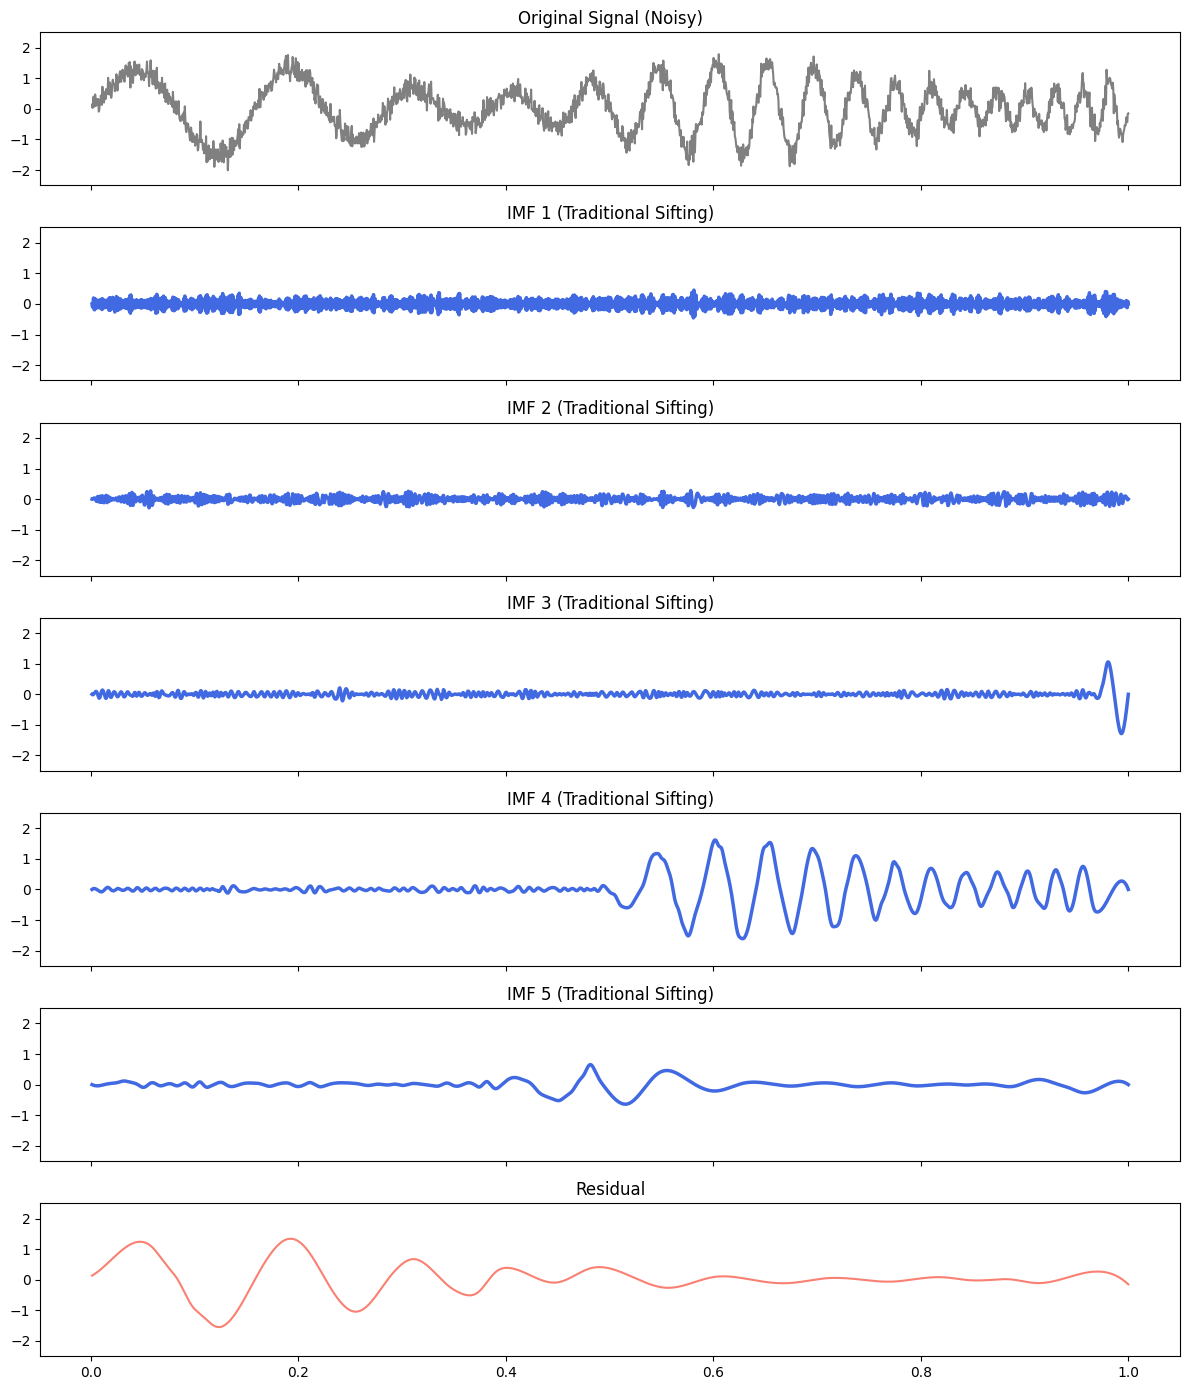

In [32]:
imfs, final_resid = traditional_emd(y_noisy, x)

n_layers = len(imfs)
fig, axes = plt.subplots(n_layers + 2, 1, figsize=(12, 2 * (n_layers + 2)), sharex=True)

axes[0].plot(x, y_noisy, color='gray', linewidth=1.5)
axes[0].set_title("Original Signal (Noisy)")
axes[0].set_ylim(-2.5, 2.5)

for i in range(n_layers):
    axes[i+1].plot(x, imfs[i], color='royalblue', linewidth=2.5)
    axes[i+1].set_title(f"IMF {i+1} (Traditional Sifting)")
    axes[i+1].set_ylim(-2.5, 2.5)

axes[-1].plot(x, final_resid, color='salmon', linewidth=1.5)
axes[-1].set_title(f"Residual")
axes[-1].set_ylim(-2.5, 2.5)

plt.tight_layout()
plt.show()